C:\Users\piocr\anaconda3\envs\snakes\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


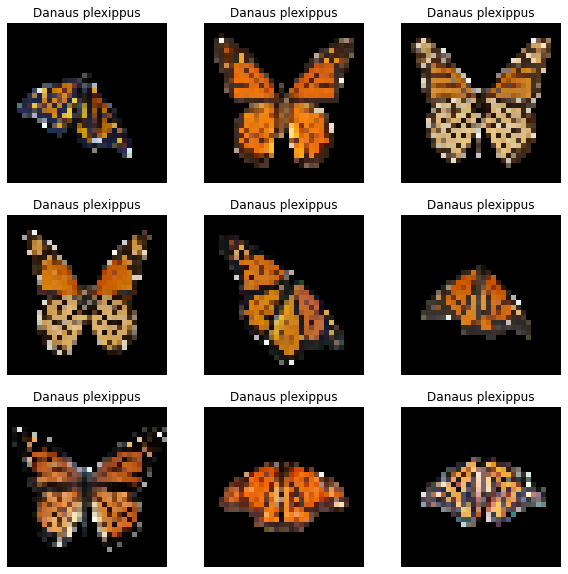

In [1]:
import os
import numpy as np
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

# Makes one figure able to display multiple pictures
def display_multiple(images, titles, number = 1, rows = 1, cols=1):
    fig = plt.figure(figsize=(10, 10))
    for i in range(number):
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(titles[i])

# All the butterfly-types in the dataset
types = ['Danaus plexippus',
         'Heliconius charitonius',
         'Heliconius erato',
         'Junonia coenia',
         'Lycaena phlaeas',
         'Nymphalis antiopa',
         'Papilio cresphontes',
         'Pieris rapae',
         'Vanessa atalanta',
         'Vanessa cardui']
        
#
# Load data, greyscale
#

image_data = np.load('./Data/RGB32x32InputImage.npy')
type_name_data = np.load('./Data/RGB32x32OutputType.npy')

# Generate index based on name, as model.fit cannot use string
l = []
for name in type_name_data:
    l.append(types.index(name))
type_index_data = np.asarray(l)

display_multiple(image_data, type_name_data, 9, 3, 3)

In [2]:
#
# Splitting and Preprocessing data
#
num_classes = 10
input_shape = (32, 32, 3)

x_train, x_test, y_train, y_test = train_test_split(image_data, type_index_data, test_size=0.33)

x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape)
print(y_train.shape)

(557, 32, 32, 3)
(557,)


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


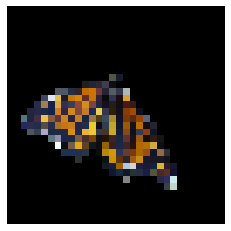

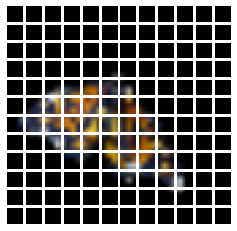

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = image_data[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [9]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [10]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    start = time.time()
    
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    
    training_time = time.time() - start

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_3_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print('\nTraining time in seconds:', training_time)
    print(f"Test top 3 accuracy: {round(top_3_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
2/2 [==============================] - 12s 1s/step - loss: 8.6762 - accuracy: 0.1058 - top-3-accuracy: 0.3194 - val_loss: 7.4968 - val_accuracy: 0.1250 - val_top-3-accuracy: 0.2857
Epoch 2/100
2/2 [==============================] - 1s 306ms/step - loss: 9.1356 - accuracy: 0.1297 - top-3-accuracy: 0.3832 - val_loss: 10.1374 - val_accuracy: 0.1250 - val_top-3-accuracy: 0.3214
Epoch 3/100
2/2 [==============================] - 1s 300ms/step - loss: 9.2625 - accuracy: 0.1856 - top-3-accuracy: 0.4092 - val_loss: 3.0639 - val_accuracy: 0.1964 - val_top-3-accuracy: 0.4464
Epoch 4/100
2/2 [==============================] - 1s 299ms/step - loss: 5.0864 - accuracy: 0.1756 - top-3-accuracy: 0.4212 - val_loss: 2.5724 - val_accuracy: 0.1607 - val_top-3-accuracy: 0.3750
Epoch 5/100
2/2 [==============================] - 1s 328ms/step - loss: 3.5617 - accuracy: 0.1557 - top-3-accuracy: 0.4132 - val_loss: 2.1191 - val_accuracy: 0.2679 - val_top-3-accuracy: 0.4286
Epoch 6/100
2/2 [=========

Epoch 43/100
2/2 [==============================] - 1s 303ms/step - loss: 0.7803 - accuracy: 0.7066 - top-3-accuracy: 0.9461 - val_loss: 0.8285 - val_accuracy: 0.6964 - val_top-3-accuracy: 0.9107
Epoch 44/100
2/2 [==============================] - 1s 296ms/step - loss: 0.7394 - accuracy: 0.7365 - top-3-accuracy: 0.9461 - val_loss: 0.8334 - val_accuracy: 0.6429 - val_top-3-accuracy: 0.9286
Epoch 45/100
2/2 [==============================] - 1s 297ms/step - loss: 0.7485 - accuracy: 0.7365 - top-3-accuracy: 0.9561 - val_loss: 0.8590 - val_accuracy: 0.6607 - val_top-3-accuracy: 0.9286
Epoch 46/100
2/2 [==============================] - 1s 291ms/step - loss: 0.7326 - accuracy: 0.7126 - top-3-accuracy: 0.9541 - val_loss: 0.9032 - val_accuracy: 0.6429 - val_top-3-accuracy: 0.9464
Epoch 47/100
2/2 [==============================] - 1s 293ms/step - loss: 0.6750 - accuracy: 0.7365 - top-3-accuracy: 0.9601 - val_loss: 0.8558 - val_accuracy: 0.5893 - val_top-3-accuracy: 0.9464
Epoch 48/100
2/2 [==

Epoch 85/100
2/2 [==============================] - 1s 306ms/step - loss: 0.2319 - accuracy: 0.9102 - top-3-accuracy: 0.9940 - val_loss: 0.5325 - val_accuracy: 0.8214 - val_top-3-accuracy: 1.0000
Epoch 86/100
2/2 [==============================] - 1s 303ms/step - loss: 0.2398 - accuracy: 0.9082 - top-3-accuracy: 0.9960 - val_loss: 0.3874 - val_accuracy: 0.8571 - val_top-3-accuracy: 0.9821
Epoch 87/100
2/2 [==============================] - 1s 304ms/step - loss: 0.1680 - accuracy: 0.9441 - top-3-accuracy: 0.9960 - val_loss: 0.4397 - val_accuracy: 0.8214 - val_top-3-accuracy: 1.0000
Epoch 88/100
2/2 [==============================] - 1s 302ms/step - loss: 0.2421 - accuracy: 0.9301 - top-3-accuracy: 1.0000 - val_loss: 0.4215 - val_accuracy: 0.8750 - val_top-3-accuracy: 1.0000
Epoch 89/100
2/2 [==============================] - 1s 304ms/step - loss: 0.2264 - accuracy: 0.9281 - top-3-accuracy: 0.9960 - val_loss: 0.5186 - val_accuracy: 0.8214 - val_top-3-accuracy: 1.0000
Epoch 90/100
2/2 [==

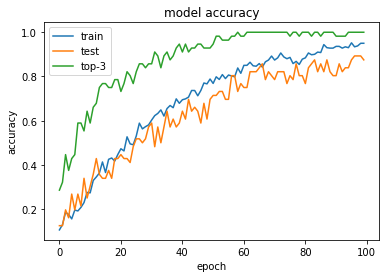

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_top-3-accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test','top-3'], loc='upper left')
plt.show()